<a href="https://colab.research.google.com/github/codeforever200/Crypto_Currency_Forecasting_and_Analsysis/blob/main/btc_arima_lstmipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data from Bitmex API


In [ ]:
!pip install bitmex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.9 MB/s eta 0:00:00


In [ ]:
# IMPORTS

import pandas as pd
import numpy as np
import math
import os.path
import time
from bitmex import bitmex
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
import requests
import time
import hmac
import hashlib
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy import stats

In [ ]:
### API
bitmex_api_key = 'I_4iX_04vIf8wq6a2VDyg2In'
bitmex_api_secret = 'Alnt16ufGGRZYUztBb3ZdQf2ZZ7em5vpxhIoHrVmj8Mpvf4c'

In [ ]:
### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
bitmex_client = bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)

/usr/local/lib/python3.10/dist-packages/swagger_spec_validator/validator20.py:49: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  warnings.warn(


In [ ]:
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

In [ ]:
def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [ ]:
df_1h = get_all_bitmex("XBTUSD","1h",save = True)

In [ ]:
df_1h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67110 entries, 2015-09-25 13:00:00+00:00 to 2023-05-22 18:00:00+00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   symbol           67110 non-null  object 
 1   open             67110 non-null  float64
 2   high             67110 non-null  float64
 3   low              67110 non-null  float64
 4   close            67110 non-null  float64
 5   trades           67110 non-null  int64  
 6   volume           67110 non-null  int64  
 7   vwap             66860 non-null  float64
 8   lastSize         66860 non-null  float64
 9   turnover         67110 non-null  int64  
 10  homeNotional     67110 non-null  float64
 11  foreignNotional  67110 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 6.7+ MB


In [ ]:
df_1h.reset_index(level=0, inplace=True)
df_1h = df_1h.dropna()
df_1h.head()

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
0,2015-09-25 13:00:00+00:00,XBTUSD,239.99,239.99,237.36,237.45,10,11501,237.418,500.0,2730544990,27.305450,6482.806927
1,2015-09-25 14:00:00+00:00,XBTUSD,237.45,237.05,236.08,236.08,6,22625,236.242,7500.0,5344986250,53.449863,12627.134051
2,2015-09-25 15:00:00+00:00,XBTUSD,236.08,236.52,236.10,236.34,13,17434,236.265,500.0,4119046040,41.190460,9731.870764
3,2015-09-25 16:00:00+00:00,XBTUSD,236.34,236.13,235.44,235.71,15,26900,235.732,1500.0,6341186000,63.411860,14948.208390
4,2015-09-25 17:00:00+00:00,XBTUSD,235.71,236.01,235.46,235.75,22,29200,235.793,1500.0,6885159000,68.851590,16234.735419


In [ ]:
df_1h.to_csv('bitcoin_1h.csv', index=False)

In [ ]:
# Printing the start date and End date of the dataset

sd=df_1h.iloc[0][0]
ed=df_1h.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2015-09-25 13:00:00+00:00
Ending Date 2023-05-08 17:00:00+00:00


In [ ]:
# year 2015-18

split = '2018-01-01'
df_15_17 =  df_1h.loc[df_1h['timestamp'] < split]

In [ ]:
# Year 2018-21

split_h = '2018-01-01'
split_t = '2021-01-01'
df =  df_1h.loc[ df_1h['timestamp'] < split_t]
df_18_20 = df[ df['timestamp'] >= split_h]

In [ ]:
# Year 2021-23

split_h = '2021-01-01'
df_21_23 = df_1h[ df_1h['timestamp'] >= split_h]

TypeError: ignored

In [ ]:
df_21_23.tail()

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
66768,2023-05-08 13:00:00+00:00,XBTUSD,28050.0,28046.5,27783.0,27810.0,6580,45696400,27931.0884,500.0,163604322144,1636.043221,45696400.0
66769,2023-05-08 14:00:00+00:00,XBTUSD,27810.0,28010.5,27768.5,27896.0,4957,27627500,27889.7240,200.0,99060012003,990.600120,27627500.0
66770,2023-05-08 15:00:00+00:00,XBTUSD,27896.0,28039.5,27712.0,28020.5,4710,38956200,27866.8744,100.0,139794248172,1397.942482,38956200.0
66771,2023-05-08 16:00:00+00:00,XBTUSD,28020.5,28129.5,27900.0,27954.0,3769,18075900,27994.8937,500.0,64568717741,645.687177,18075900.0
66772,2023-05-08 17:00:00+00:00,XBTUSD,27954.0,28000.0,27904.0,27942.0,2487,16892700,27955.4502,3100.0,60427376847,604.273768,16892700.0


In [ ]:
print('Total number of days present in the dataset: ',df_1h.shape[0])
print('Total number of fields present in the dataset: ',df_1h.shape[1])

Total number of days present in the dataset:  66519
Total number of fields present in the dataset:  13


<Axes: title={'center': 'Bitcoin Closing Prices (2015-23)'}, xlabel='timestamp'>

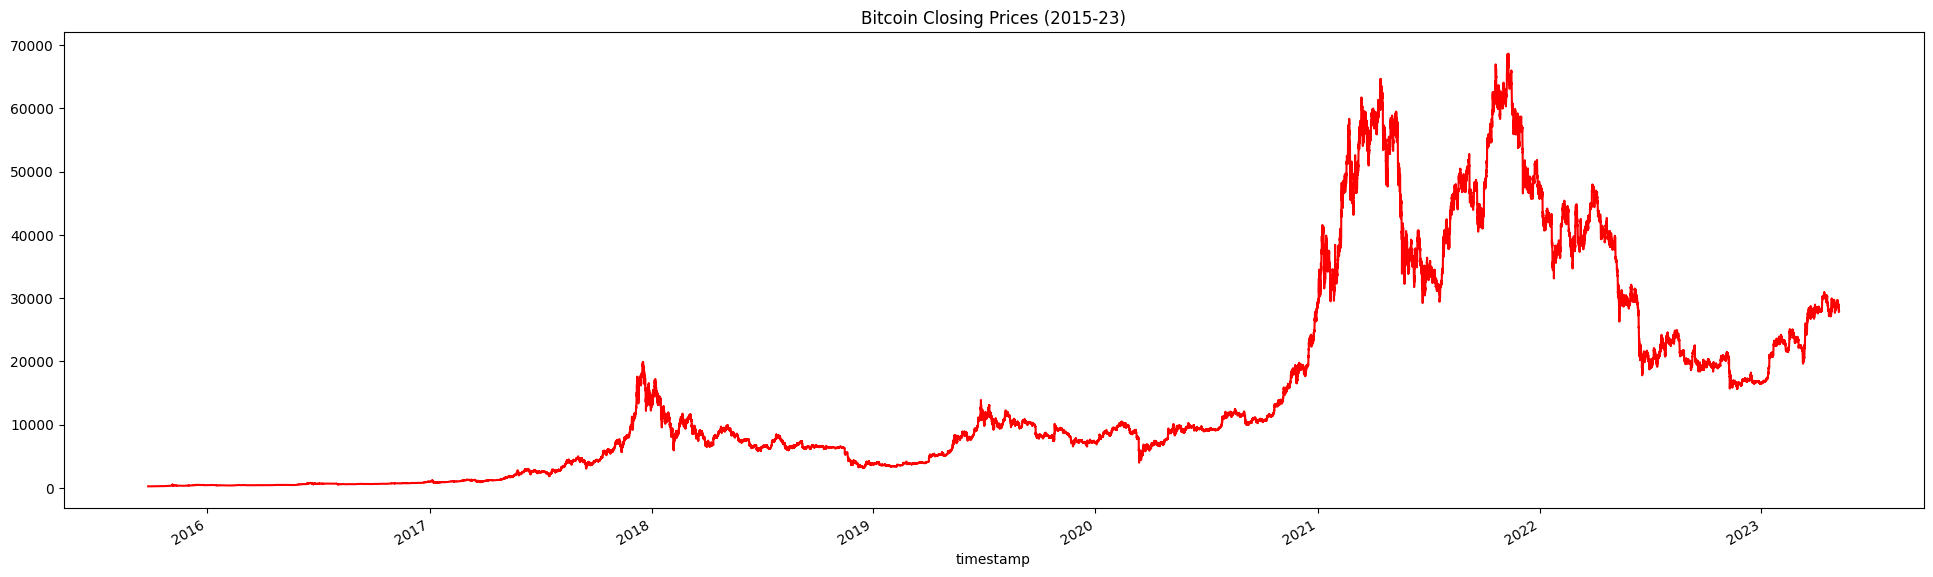

In [ ]:
df_1h.set_index("timestamp").close.plot(figsize=(24,7), title="Bitcoin Closing Prices (2015-23)",color='red')

In [ ]:
df_1h['date'] = pd.to_datetime(df_1h['timestamp'],unit='s').dt.date

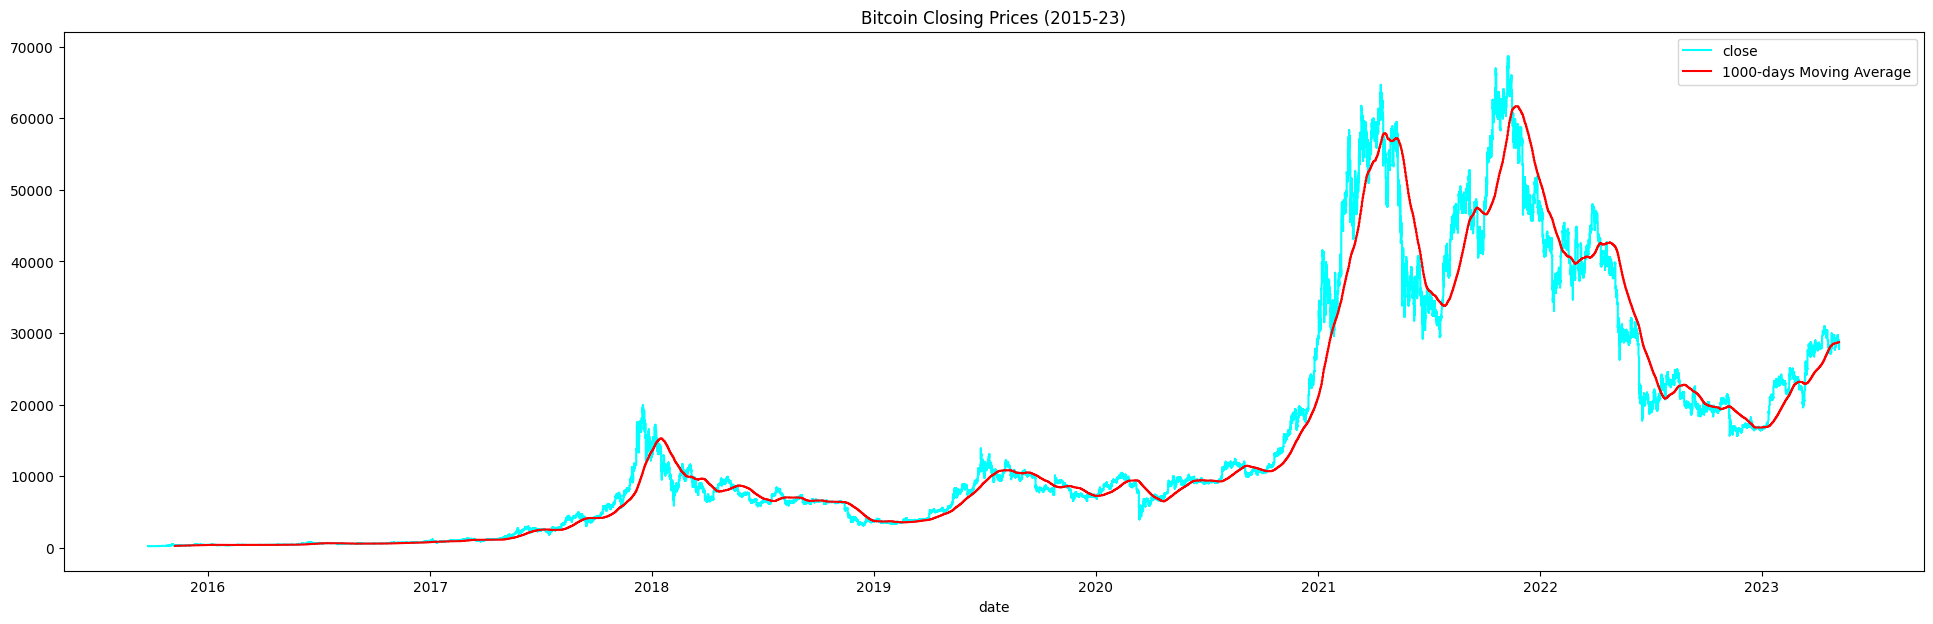

In [ ]:
# plot the closing prices
df = df_1h.set_index('date')
fig, ax = plt.subplots(figsize=(24, 7))
df['close'].plot(ax=ax, title='Bitcoin Closing Prices (2015-23)',color='cyan')

# calculate the 30-day moving average
ma = df['close'].rolling(window=1000).mean()

# plot the moving average line
ma.plot(ax=ax, label='1000-days Moving Average',color='red')

# add legend and show the plot
ax.legend()
plt.show()

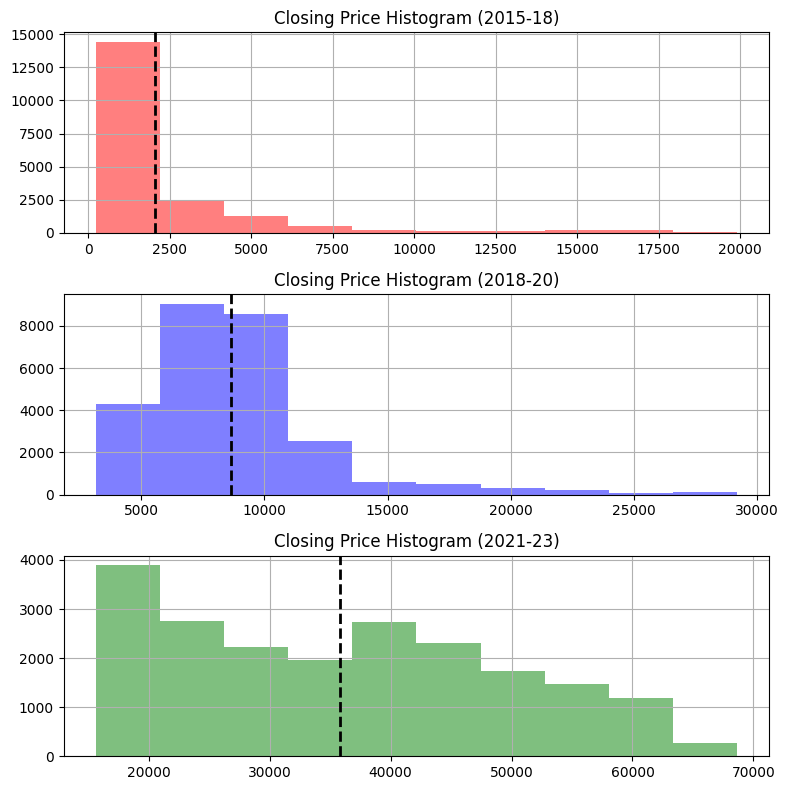

In [ ]:
# create a figure with 3 subplots arranged in a 3x1 grid
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

# plot the first dataframe on the first subplot
mean1 = df_15_17['close'].mean()
df_15_17['close'].hist(ax=axes[0], bins=10, alpha=0.5, color='red')
axes[0].axvline(mean1, color='black', linestyle='dashed', linewidth=2)
axes[0].set_title('Closing Price Histogram (2015-18)')

# plot the second dataframe on the second subplot
mean2 = df_18_20['close'].mean()
df_18_20['close'].hist(ax=axes[1], bins=10, alpha=0.5, color='blue')
axes[1].axvline(mean2, color='black', linestyle='dashed', linewidth=2)
axes[1].set_title('Closing Price Histogram (2018-20)')

# plot the third dataframe on the third subplot
mean3 = df_21_23['close'].mean()
df_21_23['close'].hist(ax=axes[2], bins=10, alpha=0.5, color='green')
axes[2].axvline(mean3, color='black', linestyle='dashed', linewidth=2)
axes[2].set_title('Closing Price Histogram (2021-23)')
# adjust the spacing between subplots
plt.tight_layout()

# show the plot
plt.show()

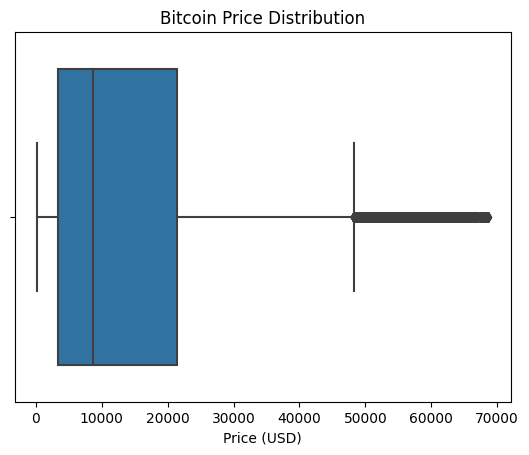

In [ ]:
import seaborn as sns

sns.boxplot(x=df_1h['close'])
plt.title('Bitcoin Price Distribution')
plt.xlabel('Price (USD)')
plt.show()

## Lag plots

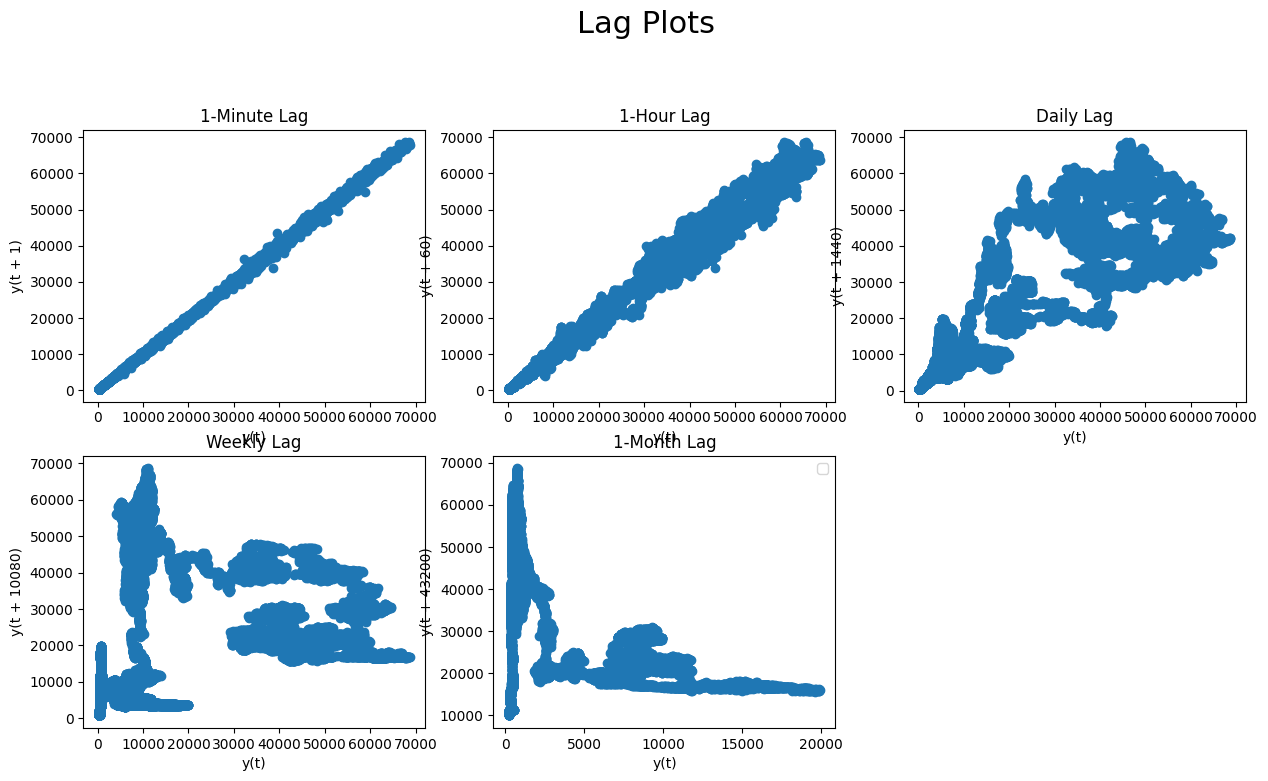

In [ ]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(df_1h['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df_1h['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df_1h['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(df_1h['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(df_1h['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

# Stationarity check and STL-decomposition of the series

### Stationarity - A Stationary series is one whose statistical properties such as mean, variance, covariance, and standard deviation do not vary with time, or these stats properties are not a function of time. In other words, stationarity in Time Series also means series without a Trend or Seasonal components.

### STL stands for Seasonal and Trend decomposition using Loess. This is a statistical method of decomposing a Time Series data into 3 components containing seasonality, trend and residual.

In [ ]:
# Resampling to daily,monthy frequency
df_1h.index = df_1h.timestamp
df_day = df_1h.resample('D').mean()
df_month = df_1h.resample('M').mean()

<ipython-input-21-78947312a8c4>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_day = df_1h.resample('D').mean()
<ipython-input-21-78947312a8c4>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month = df_1h.resample('M').mean()


### **Augmented Dickey Fuller Test**

ADF is conducted with the following assumptions:

**Null Hypothesis (HO):** Series is non-stationary, or series has a unit root.

**Alternate Hypothesis(HA):** Series is stationary, or series has no unit root.
If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

**Conditions to Reject Null Hypothesis(HO) :**

If **Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis**(HO), i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.

In [ ]:
# ADF Test on hourly data
# Function to print out results in customised manner
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(df_1h['close'])

Results of Dickey-Fuller Test:
Test Statistic                    -1.389520
p-value                            0.587290
#Lags Used                        60.000000
Number of Observations Used    66458.000000
Critical Value (1%)               -3.430448
Critical Value (5%)               -2.861583
Critical Value (10%)              -2.566793
dtype: float64


In [ ]:
# ADF Test on daily data
# Function to print out results in customised manner
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(df_day['close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.679284
p-value                           0.441817
#Lags Used                       28.000000
Number of Observations Used    2754.000000
Critical Value (1%)              -3.432727
Critical Value (5%)              -2.862590
Critical Value (10%)             -2.567329
dtype: float64


Since p-value > 0.05, we fail to reject the null hypothesis. Hence the series is non-stationary.

<Figure size 3000x1000 with 0 Axes>

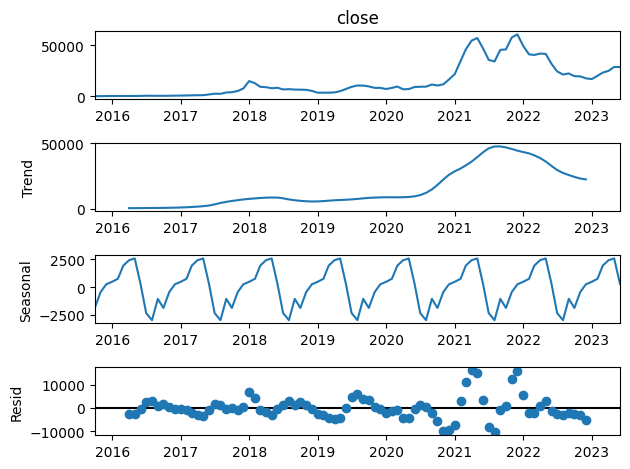

In [ ]:
plt.figure(figsize=[30,10])
sm.tsa.seasonal_decompose(df_month.close).plot()
plt.show()

### In the above plots clearly trend and seasonality can be obeserved.

In [ ]:
df_day['Weighted_Price_box'], lmbda = stats.boxcox(df_day.close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.close)[1])

Dickey–Fuller test: p=0.441817


# **KPSS Test**
The KPSS test is conducted with the following assumptions.

**Null Hypothesis (HO):** Series is trend stationary or series has no unit root.

**Alternate Hypothesis(HA):** Series is non-stationary, or series has a unit root.
Note: The hypothesis is reversed in the KPSS test compared to ADF Test.

If the null hypothesis is failed to be rejected, this test may provide evidence that the series is trend stationary.

**Conditions to Fail to Reject Null Hypothesis(HO)**

If the **Test Statistic < Critical Value and p-value < 0.05 – Fail to Reject Null Hypothesis(HO**), i.e., time series does not have a unit root, meaning it is trend stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [ ]:
kpss_test(df_day['close'])

Results of KPSS Test:
Test Statistic            5.377518
p-value                   0.010000
#Lags Used               31.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


p-value is less than 0.05, hence null value is rejected. Hence, the series is non-stationary.

## Converting Non-Stationary Into Stationary (applying 3 different methods till stationarity is obtained)

**Box-Cox Transformations** - Formally, A Box cox transformation is defined as a way to transform non-normal dependent variables in our data to a normal shape through which we can run a lot more tests than we could have.

In [ ]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.close)[1])

Dickey–Fuller test: p=0.498191


 **Seasonal differentiation**


In [ ]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.103399


**Regular differentiation**

Dickey–Fuller test: p=0.000948


<Figure size 1500x700 with 0 Axes>

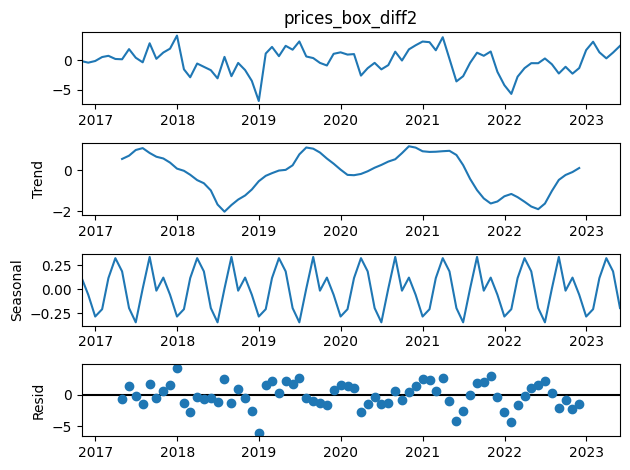

In [ ]:
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

#### Since p-value < 0.05, means we have obtained stationarity.

### Autocorrelation and Partial Autocorrelation Plots for Model Selection -

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


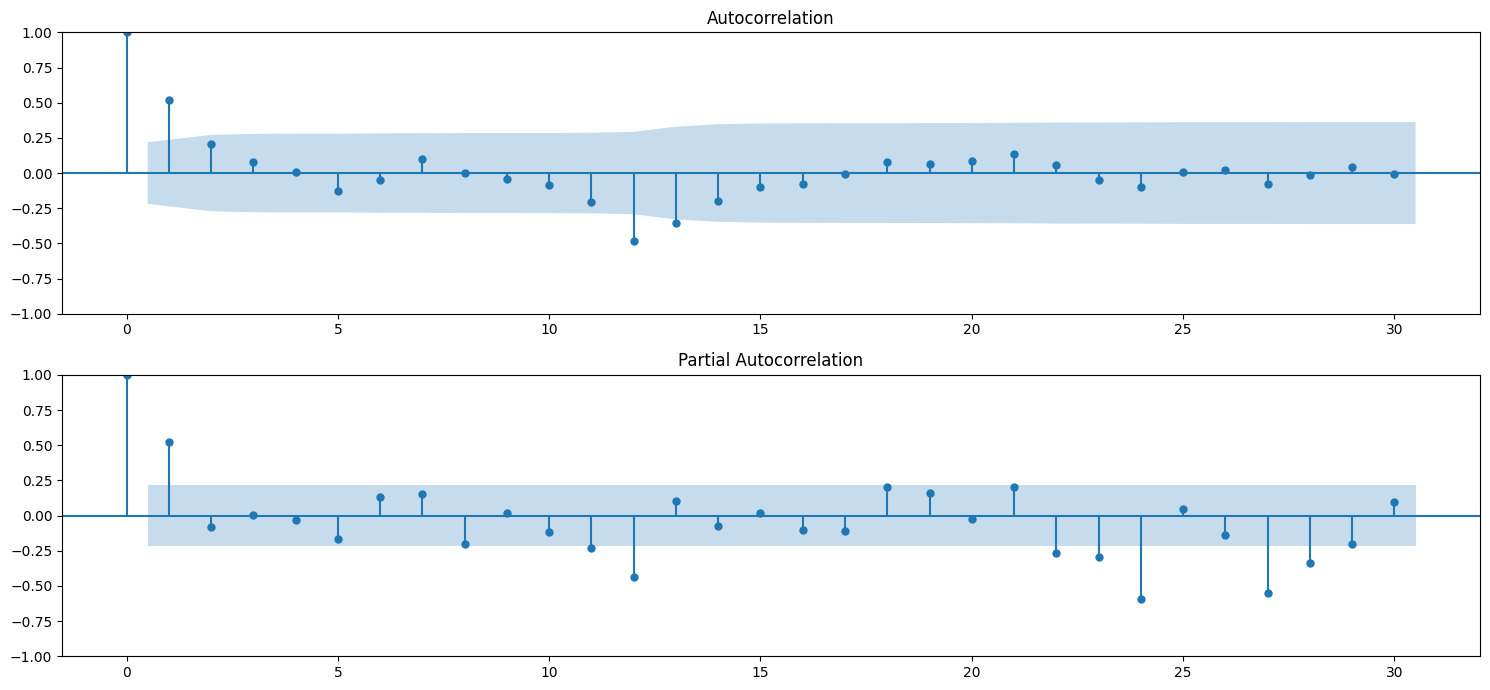

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=30, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=30, ax=ax)
plt.tight_layout()
plt.show()

Since the graph reduces gradually, the best model to fit is ARMA/ARIMA.

# **ARIMA**

In [ ]:
# Convert the data to log returns
df_1h['log_returns'] = np.log(df_1h['close']) - np.log(df_1h['close'].shift(1))
df_1h = df_1h.dropna()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import random


# Split the data into training and test sets
train_data =pd.DataFrame(df_1h['log_returns'][0:int(len(df_1h)*0.80)])
test_data =pd.DataFrame(df_1h['log_returns'][int(len(df_1h)*0.80):int(len(df_1h))])
test_data.index = range(len(train_data), len(train_data) + len(test_data))



# Define the p, d, and q parameters for the ARIMA model
p = 1
d = 0
q = 1

# Create the ARIMA model
model = ARIMA(train_data, order=(p, d, q))

# Fit the model
res = model.fit()

# Get the predicted values
pred_train = res.predict()
predicted_returns = res.predict(start=test_data.index[0], end=test_data.index[-1])

# Compute the actual returns
actual_train = train_data
actual_returns = test_data

# Calculate the RMSE and MAE for the predicted and actual returns
rmse_train = mean_squared_error(actual_train, pred_train) ** 0.5
mae_train = mean_absolute_error(actual_train, pred_train)

# Calculate the RMSE and MAE for the predicted and actual returns
rmse_pred = mean_squared_error(actual_returns, predicted_returns) ** 0.5
mae_pred = mean_absolute_error(actual_returns, predicted_returns)

print('ARIMA({},{},{}) model summary:\n{}'.format(p, d, q, res.summary()))
print('RMSE for train data:', rmse_train)
print('MAE for train data:', mae_train)

print('RMSE for test data:', rmse_pred)
print('MAE for test_data:', mae_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ARIMA(1,0,1) model summary:
                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                53487
Model:                 ARIMA(1, 0, 1)   Log Likelihood              175825.218
Date:                Mon, 22 May 2023   AIC                        -351642.435
Time:                        19:00:11   BIC                        -351606.887
Sample:                             0   HQIC                       -351631.335
                              - 53487                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   3.76e-05      2.771      0.006    3.05e-05       0.000
ar.L1          0.3824      0.032     11.970      0.000       0.320       0.445
ma.L1         -0.4232   

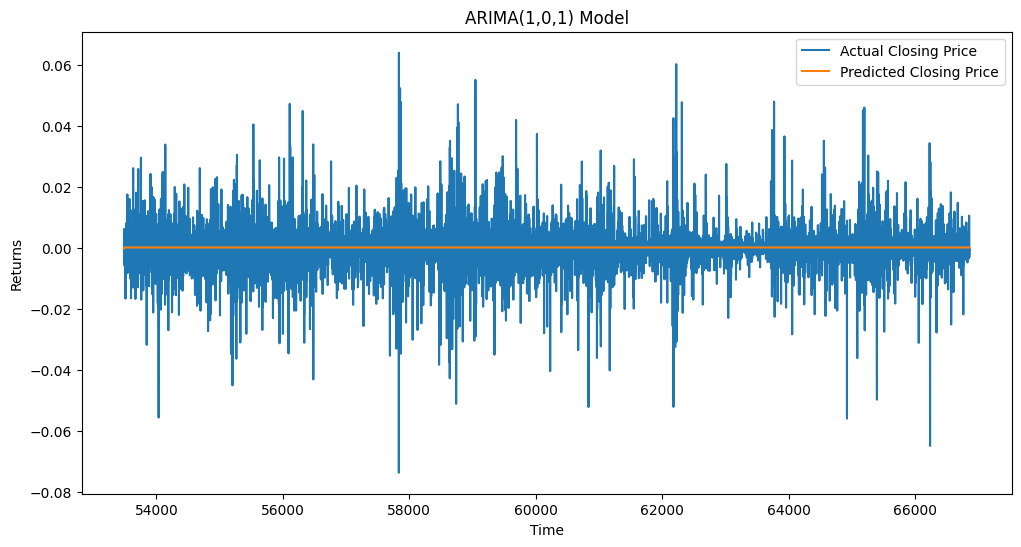

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual returns and predicted returns
plt.figure(figsize=(12,6))
plt.plot(actual_returns, label='Actual Closing Price')
plt.plot(predicted_returns, label='Predicted Closing Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('ARIMA({},{},{}) Model'.format(p, d, q))
plt.show()

In [ ]:
# Compute the predicted price ratios by exponentiating the predicted returns
predicted_price_ratios = np.exp(predicted_returns)

# Compute the cumulative sum of the predicted log returns
cumulative_predicted_returns = np.cumsum(predicted_returns)

# Compute the predicted close prices
first_close_price = df_1h['close'].iloc[53487]
close_pred_0 = first_close_price
close_pred = [close_pred_0 * np.exp(cumulative_predicted_return) for cumulative_predicted_return in cumulative_predicted_returns]

# Print the predicted close prices
print('Predicted Close Prices:')
print(close_pred,'\n')

Predicted Close Prices:
[65357.74625444931, 65357.26746711711, 65361.29098005908, 65367.036570052805, 65373.44114841646, 65380.098179335895, 65386.85219404152, 65393.64373688977, 65400.45007027768, 65407.26249868228, 65414.07769670754, 65420.89439266271, 65427.71210025875, 65434.53063356904, 65441.349921535126, 65448.16993702771, 65454.990669717445, 65461.81211569983, 65468.63427352738, 65475.45714269231, 65482.28072304617, 65489.105014577966, 65495.930017329265, 65502.75573136174, 65509.58215674476, 65516.409293550634, 65523.2371418528, 65530.06570172515, 65536.89497324172, 65543.72495647668, 65550.55565150414, 65557.38705839831, 65564.21917723335, 65571.05200808345, 65577.88555102286, 65584.71980612572, 65591.55477346633, 65598.39045311883, 65605.22684515752, 65612.06394965663, 65618.90176669037, 65625.74029633305, 65632.5795386589, 65639.4194937422, 65646.26016165725, 65653.10154247831, 65659.9436362797, 65666.7864431357, 65673.62996312065, 65680.47419630885, 65687.31914277462, 6569

In [ ]:
actual_returns

,log_returns
53487,0.002083
53488,0.000161
53489,-0.002075
53490,0.000383
53491,-0.003607
...,...
66854,0.010535
66855,-0.002039
66856,-0.002991
66857,-0.000335


In [ ]:
df_true = df_1h['close'][53487:].reset_index(drop=True)
df_pred = pd.DataFrame(close_pred, columns=['close_pred'])
df=pd.concat([df_true,df_pred], axis=1)

In [ ]:
# Convert the predicted log returns back to the original scale
predicted_returns_orig = np.exp(predicted_returns)

# Compute the actual returns in the original scale
actual_returns_orig = np.exp(actual_returns)

# Calculate the RMSE and MAE for the predicted and actual returns in the original scale
rmse_pred_orig = mean_squared_error(actual_returns_orig, predicted_returns_orig) ** 0.5
mae_pred_orig = mean_absolute_error(actual_returns_orig, predicted_returns_orig)

print('RMSE for predicted returns (original scale):', rmse_pred_orig)
print('MAE for predicted returns (original scale):', mae_pred_orig)

RMSE for predicted returns (original scale): 0.006521432805226382
MAE for predicted returns (original scale): 0.004053751917993293


In [ ]:
actual_returns_orig

,log_returns
53487,1.002085
53488,1.000161
53489,0.997928
53490,1.000383
53491,0.996400
...,...
66854,1.010591
66855,0.997963
66856,0.997013
66857,0.999665


# LSTM

In [ ]:
df_19_23 = df_1h[28399:]

In [ ]:
# import libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# load data
#df.index = pd.to_datetime(df.index)


dataset = df_19_23[['close']].values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# create training and testing data
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# create function to create dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape data
look_back = 5
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# define optimizer
optimizer = Adam(lr=0.001, clipvalue=1.0)
#optimizer='adam'

# define and train model LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
# define callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

# train model
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2, callbacks=[es], validation_split=0.2)
#model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
674/674 - 7s - loss: 0.0112 - val_loss: 7.6298e-05 - 7s/epoch - 11ms/step
Epoch 2/100
674/674 - 2s - loss: 7.7317e-05 - val_loss: 9.2532e-05 - 2s/epoch - 3ms/step
Epoch 3/100
674/674 - 2s - loss: 5.2325e-05 - val_loss: 1.6341e-04 - 2s/epoch - 3ms/step
Epoch 4/100
674/674 - 3s - loss: 4.4767e-05 - val_loss: 1.7180e-04 - 3s/epoch - 4ms/step
Epoch 5/100
674/674 - 2s - loss: 4.1463e-05 - val_loss: 1.5778e-04 - 2s/epoch - 3ms/step
Epoch 6/100
674/674 - 2s - loss: 3.8647e-05 - val_loss: 1.4073e-04 - 2s/epoch - 2ms/step
Epoch 7/100
674/674 - 2s - loss: 3.5372e-05 - val_loss: 1.2647e-04 - 2s/epoch - 3ms/step
Epoch 8/100
674/674 - 2s - loss: 3.2506e-05 - val_loss: 1.1357e-04 - 2s/epoch - 3ms/step
Epoch 9/100
674/674 - 2s - loss: 2.9175e-05 - val_loss: 1.0545e-04 - 2s/epoch - 3ms/step
Epoch 10/100
674/674 - 2s - loss: 2.7064e-05 - val_loss: 9.3120e-05 - 2s/epoch - 3ms/step
Epoch 11/100
674/674 - 2s - loss: 2.4776e-05 - val_loss: 8.7432e-05 - 2s/epoch - 4ms/step
Epoch 11: early stoppi

In [ ]:
test_p = testPredict.reshape(-1, 1)

test_y = testY.reshape(-1, 1)

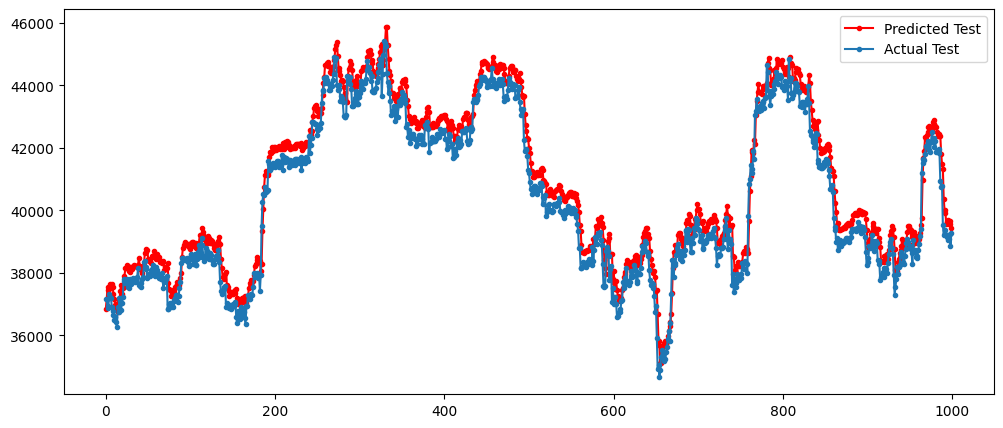

In [ ]:
plt.figure(figsize=(12,5))


# Plot a subset of the data
plt.plot(test_p[:1000], 'r', marker='.', label='Predicted Test')
plt.plot(test_y[:1000], marker='.', label='Actual Test')
plt.legend()

# Display the plot
plt.show()
